In [1]:
import random
from collections import Counter, defaultdict
from pymongo import MongoClient
import pickle
import os
import json
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from utils import *
from sklearn.metrics.pairwise import cosine_similarity
import jieba
import re
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import cohen_kappa_score
import scipy.stats as stats
from scipy.stats import pearsonr

# Build Dataset

In [2]:
# ----------- GENERAL OBJECTS ----------- # 
# TODO: change mongodb to dataframe

# %run "[POST-Class] System Predictions (based on mongodb).ipynb" # SysPrediction
%run "[Class] User Peer Feedback (based on gen-0).ipynb" # UserFeedback, PeerAssessment

PATH = "data/user-study/"
df_user = pd.read_pickle(os.path.join(PATH, "df_user.pkl"))
df_peer = pd.read_pickle(os.path.join(PATH, "df_peer.pkl"))
df_item = pd.read_pickle(os.path.join(PATH, "df_up_items.pkl")) # outer join

# sys_predictions = SysPrediction()
user_feedback = UserFeedback(df_user)
peer_assess = PeerAssessment(df_peer)

In [3]:
# data preprocessing
# TODO: anonymilization
user_ids = [
    "u_15810795617",
    "u_17801182378",
    "u_15313346392",
    "u_18222716322",
    "u_15071347094",
    "u_18712328742",
    "u_15900292575",
    "u_19920091165",
    "u_18221771895",
    "u_18811400801",
    "u_18811195178",
    "u_19801210262",
    "u_18993873008",
    "u_13701195791",
    "u_18800182977",
    "u_18801378212"
]
df_item = df_item[df_item['user_id'].isin(user_ids)].copy()
df_user = df_user[df_user['user_id'].isin(user_ids)].copy()
df_peer = df_peer[df_peer['user_id'].isin(user_ids)].copy()

In [4]:
# add algorithm results
client = MongoClient('mongodb://127.0.0.1:27017', username='', password="")
ui_algos = {}
for urec in client.Assess.user_phase2_recommend_top3.find(): # user_phase2_recommend_top3 is the rec data used in user study.
    for trec in urec['rec_list']:
        ui_algos[(urec['user_id'], trec['item'])] = dict(trec['algorithms'])
df_item['algorithms'] = list(map(lambda t: ui_algos[(t[0], t[1])] if (t[0], t[1]) in ui_algos else {},
                                      zip(df_item['user_id'], df_item['movie_id'])))

# remove nan
df_item.dropna(subset=['peer_preference'], inplace=True)
df_item.reset_index(drop=True, inplace=True)

# Statsitics

In [5]:
print ("Number of users: {}".format(len(set(df_item['user_id']))))
print ("Number of peers: {}".format(len(set(df_item['peer_id']))))
print ("Number of <user, item> feedback: {}".format(len(set(zip(df_item['user_id'], df_item['movie_id'])))))
print ("Number of <user, item, peer> annotation: {}".format(len(set(zip(df_item['user_id'], df_item['movie_id'], df_item['peer_id'])))))

Number of users: 16
Number of peers: 19
Number of <user, item> feedback: 284
Number of <user, item, peer> annotation: 870


In [6]:
# attribute number 
total = 0.0
for (u, i), tdf in df_item.groupby(['user_id', "movie_id"]):
    attrs = tdf.iloc[0]['self_attributes']
    if type(attrs) == list and len(attrs) > 0:
        total += len(tdf.iloc[0]['self_attributes'])
print ("Number of attribute-level self-preference feedback: {}".format(int(total)))

# Section 3.3 Participants and data statisitics: self-attribute feedback. 
total = 0.0
for (p, u, i), tdf in df_item.groupby(['peer_id', 'user_id', "movie_id"]):
    attrs = tdf.iloc[0]['peer_attributes']
    if type(attrs) == list and len(attrs) > 0:
        total += len(tdf.iloc[0]['peer_attributes'])
print ("Number of attribute-level peer-assessment: {}".format(int(total)))

Number of attribute-level self-preference feedback: 3908
Number of attribute-level peer-assessment: 11099


# Inter-Assessor Agreement

    requirments: krippendorff.py

    S4.1 how assessors agree with each other

In [7]:
from krippendorff import *
ui_idx = list(set([(u, i) for u, i in zip(df_item['user_id'], df_item['movie_id'])]))
peer_labels = []

for tp in set(df_item['peer_id']):
    plabels = [np.nan for _ in ui_idx]
    pitem = df_item[df_item['peer_id'] == tp]
    for i, tr in pitem.iterrows():
        u, i = tr['user_id'], tr['movie_id']
        l = int(tr['peer_preference'])
        plabels[ui_idx.index((u, i))] = l
    peer_labels.append(plabels)
    
print("Krippendorff's alpha:", round(alpha(peer_labels, level_of_measurement='ordinal'), 3))
# Table 1: Krippendorff's alpha

Krippendorff's alpha: 0.425


In [9]:
# 4.1 Comparison to literature and Summary (overlap)

peer_labels = np.array(peer_labels)
rel_intset = []
rel_union = []
for j in range(peer_labels.shape[1]):
    ls = [1 if t <= 3 else 0 for t in peer_labels[:,j] if not pd.isnull(t)]
    if len(ls) < 2:
        print ("Error")
    if sum(ls) > 0:
        rel_union.append(j)
    if sum(ls) == len(ls):
        rel_intset.append(j)

# three assessors
# Comparison to the literature and summary
print (len(rel_intset), len(rel_union), "Overlap (three):", len(rel_intset) / float(len(rel_union)))


rel_intset = []
rel_union = []
for j in range(peer_labels.shape[1]):
    ls = [1 if t <= 3 else 0 for t in peer_labels[:,j] if not pd.isnull(t)]
    if len(ls) < 2:
        print ("Error")
    if len(ls) > 2:
        ls = ls[:2]
    if sum(ls) > 0:
        rel_union.append(j)
    if sum(ls) == len(ls):
        rel_intset.append(j)

# two assessors
# Comparison to the literature and summary
print (len(rel_intset), len(rel_union), "Overlap (two):", len(rel_intset) / float(len(rel_union)))

67 206 Overlap (three): 0.32524271844660196
87 186 Overlap (two): 0.46774193548387094


## individual assessor

    cohen's kappa, fleiss's kappa

In [10]:
ui_idx = list(set([(u, i) for u, i in zip(df_item['user_id'], df_item['movie_id'])]))
peer_labels = []
for tp in set(df_item['peer_id']):
    plabels = [np.nan for _ in ui_idx]
    pitem = df_item[df_item['peer_id'] == tp]
    for i, tr in pitem.iterrows():
        u, i = tr['user_id'], tr['movie_id']
        l = int(tr['peer_preference'])
        plabels[ui_idx.index((u, i))] = l
    peer_labels.append(plabels)
    
peer_lo_alpha = []
for i in range(len(peer_labels)):
    lo_peer_labels = [list(t) for t in peer_labels]
    lo_peer_labels[i] = [np.nan for _ in range(len(lo_peer_labels[i]))]
    peer_lo_alpha.append((i, alpha(lo_peer_labels, level_of_measurement='ordinal')))
# pd.DataFrame.from_records(peer_lo_alpha, columns=['peer_id', 'alpha'])

In [11]:
upper = np.mean([t[1] for t in peer_lo_alpha]) + 2 * np.std([t[1] for t in peer_lo_alpha])
lower = np.mean([t[1] for t in peer_lo_alpha]) - 2 * np.std([t[1] for t in peer_lo_alpha])

In [12]:
max([t[1] for t in peer_lo_alpha]) - 0.425, min([t[1] for t in peer_lo_alpha]) - 0.425

(0.04270918723864786, -0.03657851200690193)

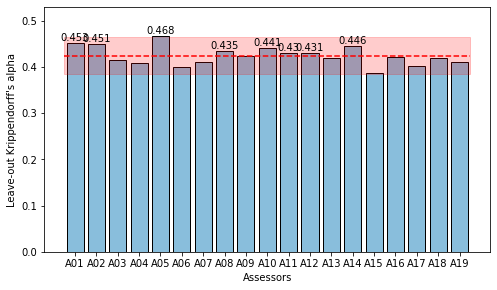

In [14]:
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-4]

plt.figure(figsize=(8, 4.5))
for x, y in zip(range(len(peer_lo_alpha)), [t[1] for t in peer_lo_alpha]):
    # if x > 15:
    #    break
    if y > 0.425:
        plt.bar([x], [y], color=blue, edgecolor="k")
        plt.text(x, y, round(y, 3), ha="center", va="bottom")
    else:
        plt.bar([x], [y], color=blue, edgecolor="k")

# plt.plot([-0.5, 11.5], [upper, upper], '--r', lw=1)
# plt.plot([-0.5, 11.5], [lower, lower], '--r', lw=1)

plt.fill_between([-0.5, 18.5], [upper, upper], [lower, lower], color="r", alpha=0.2, zorder=3)
plt.plot([-0.5, 18.5], [0.425, 0.425], '--r')
plt.ylim(0.0, 0.53)
plt.xticks(range(len(peer_lo_alpha)), ["A{}".format(str(t).zfill(2)) for t in range(1, len(peer_lo_alpha) + 1)])
plt.ylabel("Leave-out Krippendorff's alpha")
plt.xlabel("Assessors")
plt.savefig("figures/assessor_alpha.pdf", bbox_inches="tight")

## item-level

In [15]:
from itertools import combinations
def build_item_labels(df_item, key="peer_preference", bfun=lambda t: t, labels=range(1, 6)):
    item_labels = []
    for (u, i), tdf in df_item.groupby(by=['user_id', 'movie_id']):
        for v1, v2 in combinations([bfun(t) for t in tdf[key]], 2):
            item_labels.append((v1, v2))
    return item_labels

item_labels = np.array(build_item_labels(df_item, bfun=lambda t: t))

# Table 1: 5-scale percentage agreement. line-6
print (sum(item_labels[:,0] == item_labels[:,1]) / float(len(item_labels)))
# Table 1: pearson's r. line-8
print (pearsonr(item_labels[:,0], item_labels[:,1]))

0.37637969094922735
(0.4149828643210562, 5.048543481566629e-39)


In [18]:
from itertools import combinations
def build_item_labels(df_item, key="peer_preference", bfun=lambda t: t, labels=range(1, 6)):
    item_labels = []
    for (u, i), tdf in df_item.groupby(by=['user_id', 'movie_id']):
        for v1, v2 in combinations([bfun(t) for t in tdf[key]], 2):
            item_labels.append((v1, v2))
    return item_labels

item_labels = np.array(build_item_labels(df_item, bfun=lambda t: 1 if t > 3 else 0))

# Table 1: 2-scale percentage agreement.
print (sum(item_labels[:,0] == item_labels[:,1]) / float(len(item_labels)))

0.6777041942604857


## within-peer nomalized 

In [19]:
def build_normalizer(df_item, value="peer_preference", key="peer_id"):
    ans = {}
    for k, tdf in df_item.groupby(key):
        ans[k] = {
            "mean": np.mean(tdf[value]),
            "std": np.std(tdf[value])
        }
    return ans
peer_pref_stats = build_normalizer(df_item)

def _norm(pid, v):
    mean, std = peer_pref_stats[pid]['mean'], peer_pref_stats[pid]['std']
    return (v - mean) / std

df_item['peer_preference_norm'] = list(map(lambda t: _norm(t[0], t[1]), zip(df_item['peer_id'], df_item['peer_preference'])))

In [20]:
item_labels = np.array(build_item_labels(df_item, key="peer_preference_norm", bfun=lambda t: t))
print ("PCC", pearsonr(item_labels[:,0], item_labels[:,1]))
# Table 1: pearson's r (normalized pref.)

PCC (0.5029837925619483, 2.9080991097517277e-59)


## Pairwise comparison

In [31]:
def build_item_pairs_within_user(df_item, key="user_id", value="movie_id"):
    ans = []
    for u, tdf in df_item.groupby(key):
        for v1, v2 in combinations(set(tdf[value]), 2):
            if random.random() > 0.5:
                v1, v2 = v2, v1
            ans.append((u, v1, v2))
    return ans

random.seed(2021)
user_itempairs = build_item_pairs_within_user(df_item)

In [32]:
peer_labels = []
for tp in set(df_item['peer_id']):
    plabels = [np.nan for _ in user_itempairs]
    pitem = df_item[df_item['peer_id'] == tp]
    p_ui_r = {}
    for u, i, r in zip(pitem['user_id'], pitem['movie_id'], pitem['peer_preference']):
        p_ui_r[(u, i)] = r
    
    plabels = []
    for u, i1, i2 in user_itempairs:
        if (u, i1) in p_ui_r and (u, i2) in p_ui_r:
            r1, r2 = p_ui_r[(u, i1)], p_ui_r[(u, i2)]
            plabels.append( 1 if  r1 < r2 else 2 if r1 == r2 else r1 > r2 )
        else:
            plabels.append(np.nan)
    peer_labels.append(plabels)
    
# print("Krippendorff's alpha:", round(alpha(peer_labels, level_of_measurement='ordinal'), 3))

In [33]:
peer_labels = np.array(peer_labels)
print ("#pairs:", peer_labels.shape[1])
corr_cnt, all_cnt = 0, 0
for j in range(peer_labels.shape[1]):
    vs = [t for t in peer_labels[:,j] if not pd.isnull(t)]
    if len(vs) >= 2:
        if (vs[0] == vs[1]):
            corr_cnt += 1
        all_cnt += 1

# Table 1: concordance
print (corr_cnt / float(all_cnt), all_cnt)

peer_labels = np.array(peer_labels)
print ("#pairs:", peer_labels.shape[1])
corr_cnt, all_cnt = 0, 0
for j in range(peer_labels.shape[1]):
    vs = [t for t in peer_labels[:,j] if not pd.isnull(t)]
    if len(vs) >= 2:
        if vs[0] != 2:
            if (vs[0] == vs[1]):
                corr_cnt += 1
            all_cnt += 1
# Table 1: concordance (filter equal cases)
print (corr_cnt / float(all_cnt), all_cnt)

#pairs: 2383
0.5933697020562316 2383
#pairs: 2383
0.6664641555285541 1646
